# Capstone 3 Modeling (5yr AA)

**The Data Science Method**  

1.   Problem Identification 

2.   Data Wrangling 
  * Data Collection 
   * Data Organization
  * Data Definition 
  * Data Cleaning
 
3.   Exploratory Data Analysis
 * Build data profile tables and plots
        - Outliers & Anomalies
 * Explore data relationships
 * Identification and creation of features

4.   Pre-processing and Training Data Development
  * Create dummy or indicator features for categorical variables
  * Standardize the magnitude of numeric features
  * Split into testing and training datasets
  * Apply scaler to the testing set
  
5.   **Modeling**
  * Fit Models with Training Data Set
  * Review Model Outcomes — Iterate over additional models as needed.
  * Identify the Final Model

6.   Documentation
  * Review the Results
  * Present and share your findings - storytelling
  * Finalize Code 
  * Finalize Documentation

## Data Collection

In [1]:
#load python packages
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x) #get rid of scientific notations
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import time
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from tbats import BATS, TBATS
from IPython.display import Image
%matplotlib inline

In [2]:
# switch to processed data folder
os.chdir('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Three\\data\\processed\\')
os.getcwd()

'C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Three\\data\\processed'

In [3]:
# load the combined xlsx file
df = pd.read_excel('combined.xlsx', usecols=[i for i in range(1,6)])
df.head()

,Zipcode,County,Date,Value,Bedrooms
0,94109,San Francisco County,1996-01-31,263374,1
1,90250,Los Angeles County,1996-01-31,184141,1
2,90046,Los Angeles County,1996-01-31,119677,1
3,94501,Alameda County,1996-01-31,119742,1
4,94110,San Francisco County,1996-01-31,221428,1


In [4]:
# from preprocessing, we learnt that we need to log the Value, so let's add them
df['logged_value'] = df['Value'].apply(math.log)
df.head()

,Zipcode,County,Date,Value,Bedrooms,logged_value
0,94109,San Francisco County,1996-01-31,263374,1,12.4813
1,90250,Los Angeles County,1996-01-31,184141,1,12.1235
2,90046,Los Angeles County,1996-01-31,119677,1,11.6926
3,94501,Alameda County,1996-01-31,119742,1,11.6931
4,94110,San Francisco County,1996-01-31,221428,1,12.3079


In [10]:
# break the df into 4 of them indicating the number of bedrooms and drop the county and bedrooms column
df1 = df.loc[df['Bedrooms']==1]
df2 = df.loc[df['Bedrooms']==2]
df3 = df.loc[df['Bedrooms']==3]
df4 = df.loc[df['Bedrooms']==4]
df1.head()

,Zipcode,County,Date,Value,Bedrooms,logged_value
0,94109,San Francisco County,1996-01-31,263374,1,12.4813
1,90250,Los Angeles County,1996-01-31,184141,1,12.1235
2,90046,Los Angeles County,1996-01-31,119677,1,11.6926
3,94501,Alameda County,1996-01-31,119742,1,11.6931
4,94110,San Francisco County,1996-01-31,221428,1,12.3079


In [12]:
# we will use the last 12 months as testing data, let's find the starting/ending train/test dates, and its row
print('Training Date')
print('Start:', df1.Date.unique()[0])
print('End:', df1.Date.unique()[-61])
print('Training Date')
print('Start:', df1.Date.unique()[-60], 'Row Number:', df1[df1['Date'] == df1.Date.unique()[-60]].index[0])
print('End:', df1.Date.unique()[-1])

Training Date
Start: 1996-01-31T00:00:00.000000000
End: 2015-05-31T00:00:00.000000000
Training Date
Start: 2015-06-30T00:00:00.000000000 Row Number: 112073
End: 2020-05-31T00:00:00.000000000


In [7]:
# set the train/test data
train = df1.iloc[:112073]
test = df1.iloc[112073:]

#print the ending date of train and starting date of test to see
display(train.tail(1)) #2015-05-31
test.head(1) #2015-06-30

,Zipcode,County,Date,Value,Bedrooms,logged_value
135160,92341,San Bernardino County,2019-05-31,157985,1,11.9703


,Zipcode,County,Date,Value,Bedrooms,logged_value
135161,94109,San Francisco County,2019-06-30,873283,1,13.6800


# Auto_Arima logged_value

In [15]:
# make a dataframe with date range that covers the test and forecast date so we can add the predictions
auto_arima_pred_L5 = pd.DataFrame({
    'Date': pd.date_range('2015-06-30', periods=(60), freq='M')
})

# let's iterate and record the predictions invidually, also set the timer for model score use
start = time.time()
for zipcode in list(df1.Zipcode.unique()):
    # subset the training data to the zipcode of interest use its value
    train_sub = train[train['Zipcode']==zipcode].logged_value
    # train/fit the model, since we're not differencing it with d=2, we will set sesonality
    model = auto_arima(y=train_sub, seasonal=True, m=12)
    # get prediction for next 60 months
    pred = model.predict(n_periods=60)
    # record the results to auto_arima_pred_df
    auto_arima_pred_L5[zipcode] = pred
end = time.time()
fit_time = (end-start)

# save auto_arima_pred_df
auto_arima_pred_L5.to_csv('auto_arima_pred_L5.csv', index=False)

In [16]:
# above cell commented out to save re-run time. Will proceed by loading the csv file
auto_arima_pred_L5 = pd.read_csv('auto_arima_pred_L5.csv')

In [19]:
# melt the auto_arima_pred_df and sort it
AA_pred_L5 = pd.melt(auto_arima_pred_L5, id_vars=['Date'], var_name='Zipcode', value_name='logged_value')
AA_pred_L5_sorted = AA_pred_L5.sort_values(['Date','Zipcode'])
# add a column that convert logged value to original Value
AA_pred_L5_sorted['Value'] = AA_pred_L5_sorted['logged_value'].apply(math.exp)
# have the Values in integers for easier viewing
AA_pred_L5_sorted['Value'] = AA_pred_L5_sorted['Value'].astype('int64')

# save auto_arima_pred_df
AA_pred_L5_sorted.to_csv('AA_pred_L5_sorted.csv', index=False)
AA_pred_L5_sorted.head()

,Date,Zipcode,logged_value,Value
1320,2015-06-30,90004,13.3891,652836
12060,2015-06-30,90007,13.2144,548214
12180,2015-06-30,90012,13.1299,503804
6660,2015-06-30,90016,13.1419,509861
6780,2015-06-30,90018,13.2620,574942


In [20]:
# get model score and save it as a df
auto_arima_L5_score = pd.DataFrame({
    'model':'auto_arima_L5',
    'RMSE':mean_squared_error(test.Value, AA_pred_L5_sorted[:len(test)].Value, squared=False),
    'MAE':mean_absolute_error(test.Value,AA_pred_L5_sorted[:len(test)].Value),
    'fit_time(min)': int(fit_time/60), # int(fit_time/60)
}, index=[0])
auto_arima_L5_score.to_csv('auto_arima_L5_score.csv', index=False)
auto_arima_L5_score

,model,RMSE,MAE,fit_time(min)
0,auto_arima_L5,392750.3204,280814.3921,402


In [23]:
# define a function that takes in the prediction dataframe and return the medians
def median_calc(data, nobs, val_column):
    p_medians = []
    for i in range(nobs): 
        median = data.sort_values(['Date', val_column]).iloc[240+481*i][val_column]
        p_medians.append(int(median))
    return p_medians
# define a function that takes in the prediction dataframe and return the means
def mean_calc(data, val_column):
    p_means = []
    for i in list(data.Date.unique()): # get the dates to iterate
        mean = data.loc[data['Date']==i][val_column].mean() # get the mean
        p_means.append(int(mean))
    return p_means
# create an empty list to append zillow's medians
z_medians = []
for i in range(0,293): # 293 months of data
    median = df1.sort_values(['Date','Value']).iloc[240+481*i].Value #the 241st, since zero index 240
    z_medians.append(int(median))
    
# get the zillow's means
z_means = []
for i in list(df1.Date.unique()): # get the dates to iterate
    mean = df1.loc[df1['Date']==i].Value.mean() # get the mean
    z_means.append(int(mean))

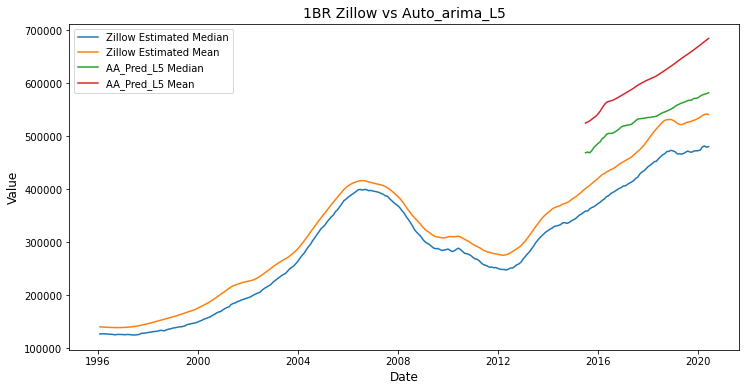

In [26]:
# plot the zillow medians/means vs predictions' medians/means
# define the x and y's
fig = plt.subplots(1,1,figsize=(12,6))
x1 = pd.date_range('1996-01-31', periods=293, freq='M')
z1 = z_medians
z2 = z_means

x2 = pd.date_range('2015-06-30', periods=60, freq='M')
p1 = median_calc(AA_pred_L5_sorted, 60, 'Value')
p2 = mean_calc(AA_pred_L5_sorted, 'Value')

# plot within same figure
fig = plt.plot(x1, z1, label='Zillow Estimated Median')
fig = plt.plot(x1, z2, label='Zillow Estimated Mean')
fig = plt.plot(x2, p1, label='AA_Pred_L5 Median')
fig = plt.plot(x2, p2, label='AA_Pred_L5 Mean')

plt.xlabel('Date', size=12)
plt.ylabel('Value', size=12)
plt.title('1BR Zillow vs Auto_arima_L5', size=14)
plt.legend()
plt.savefig('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Three\\figures\\AA_pred_L5.png')

# Auto_Arima

In [35]:
# # make a dataframe with date range that covers the test and forecast date so we can add the predictions
# auto_arima_pred5 = pd.DataFrame({
#     'Date': pd.date_range('2015-06-30', periods=(60), freq='M')
# })

# # let's iterate and record the predictions invidually, also set the timer for model score use
# start = time.time()
# for zipcode in list(df1.Zipcode.unique()):
#     # subset the training data to the zipcode of interest use its value
#     train_sub = train[train['Zipcode']==zipcode].Value
#     # train/fit the model, since we're not differencing it with d=2, we will set sesonality
#     model = auto_arima(y=train_sub, seasonal=True, m=12)
#     # get prediction for next 60 months
#     pred = model.predict(n_periods=60)
#     # record the results to auto_arima_pred_df
#     auto_arima_pred5[zipcode] = pred
# end = time.time()
# fit_time = (end-start)

# # save auto_arima_pred_df
# auto_arima_pred5.to_csv('auto_arima_pred5.csv', index=False)

In [28]:
# above cell commented out to save re-run time. Will proceed by loading the csv file
auto_arima_pred5 = pd.read_csv('auto_arima_pred5.csv')

In [29]:
# melt the auto_arima_pred_df and sort it
AA_pred5 = pd.melt(auto_arima_pred5, id_vars=['Date'], var_name='Zipcode', value_name='Value')
AA_pred5_sorted = AA_pred5.sort_values(['Date','Zipcode'])
# have the Values in integers for easier viewing
AA_pred5_sorted['Value'] = AA_pred5_sorted['Value'].astype('int64')

# save auto_arima_pred_df
AA_pred5_sorted.to_csv('AA_pred5_sorted.csv', index=False)
AA_pred5_sorted.head()

,Date,Zipcode,Value
1320,2015-06-30,90004,650866
12060,2015-06-30,90007,544652
12180,2015-06-30,90012,500884
6660,2015-06-30,90016,506866
6780,2015-06-30,90018,567713


In [30]:
# get model score and save it as a df
auto_arima_score5 = pd.DataFrame({
    'model':'auto_arima_5',
    'RMSE':mean_squared_error(test.Value, AA_pred5_sorted[:len(test)].Value, squared=False),
    'MAE':mean_absolute_error(test.Value,AA_pred5_sorted[:len(test)].Value),
    'fit_time(min)': int(fit_time/60), # int(fit_time/60)
}, index=[0])
auto_arima_score5.to_csv('auto_arima_score5.csv', index=False)
auto_arima_score5

,model,RMSE,MAE,fit_time(min)
0,auto_arima_5,386516.6023,275795.1518,149


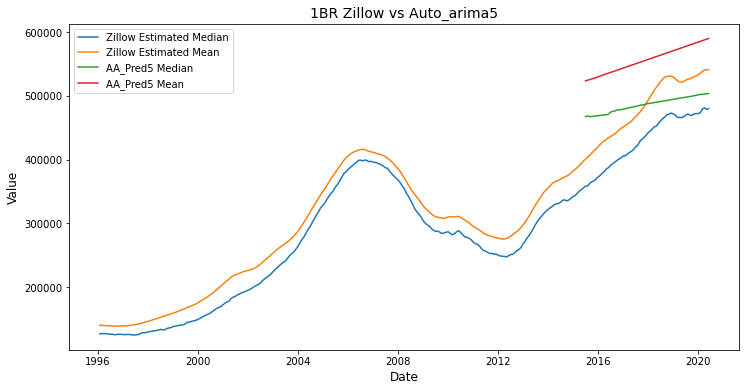

In [34]:
# plot the zillow medians/means vs predictions' medians/means
# define the x and y's
fig = plt.subplots(1,1,figsize=(12,6))
x1 = pd.date_range('1996-01-31', periods=293, freq='M')
z1 = z_medians
z2 = z_means

x2 = pd.date_range('2015-06-30', periods=60, freq='M')
p1 = median_calc(AA_pred5_sorted, 60, 'Value')
p2 = mean_calc(AA_pred5_sorted, 'Value')

# plot within same figure
fig = plt.plot(x1, z1, label='Zillow Estimated Median')
fig = plt.plot(x1, z2, label='Zillow Estimated Mean')
fig = plt.plot(x2, p1, label='AA_Pred5 Median')
fig = plt.plot(x2, p2, label='AA_Pred5 Mean')

plt.xlabel('Date', size=12)
plt.ylabel('Value', size=12)
plt.title('1BR Zillow vs Auto_arima5', size=14)
plt.legend()
plt.savefig('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Three\\figures\\AA_pred5.png')

In [36]:
# get both model's model scores
pd.concat([auto_arima_score5, auto_arima_L5_score])

,model,RMSE,MAE,fit_time(min)
0,auto_arima_5,386516.6023,275795.1518,149
0,auto_arima_L5,392750.3204,280814.3921,402


The fitting time is way too long, and the model scores are way below VARMAX, we will use VARMAX for forcasting!